<a href="https://colab.research.google.com/github/roxyrong/ml-esg-3/blob/main/eng_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

tqdm_notebook.pandas()

In [ ]:
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

# Load Data

In [2]:
data_df = pd.read_parquet("../dataset/train_df.parquet")

In [3]:
data_df = data_df[data_df["language"] == "English"]

In [4]:
data_df.head()

,url,title,content,impact_length_idx,language
0,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,ESG-focused financial technology company Arabe...,1.0,English
1,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,The company also announced the appointment of ...,1.0,English
2,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,Wong said: \n“Personalised portfolios demand ...,1.0,English
3,https://www.esgtoday.com/ukraine-war-inflation...,"Ukraine War, Inflation Reduction Act Driving F...",One of the key themes of the report is the imp...,2.0,English
4,https://www.esgtoday.com/eu-regulators-welcome...,"EU Regulators Welcome, Critique New European S...",Europe’s three primary financial regulatory ag...,0.0,English


In [11]:
data_df["sentence"] = data_df["title"] + " || " + data_df["content"]
sentences = list(data_df["sentence"])
embeddings = model.encode(sentences)
data_df["embedding"] = list(embeddings)

In [9]:
augmented_df = pd.read_parquet("../dataset/train_df_English_augmented.parquet")
sentences = list(augmented_df["sentence"])
embeddings = model.encode(sentences)
augmented_df["embedding"] = list(embeddings)

# Baseline w/o augmentation

In [35]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.5045871559633027
precision: 0.5349006402249491
recall: 0.5045871559633027
f1: 0.5096006196897165


Text(0.5, 1.0, 'Confusion Matrix')

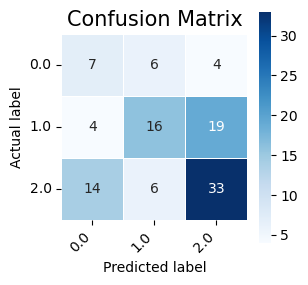

In [36]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)

# Baseline w augmentation

In [37]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  
  X_train_augmented = np.stack(augmented_df["embedding"])
  y_train_augmented = np.stack(augmented_df["impact_length_idx"])
  
  X_train = np.vstack([X_train, X_train_augmented])
  y_train = np.hstack([y_train, y_train_augmented])
  
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.5009174311926605
precision: 0.5236055594115212
recall: 0.5009174311926605
f1: 0.5035887746415197


Text(0.5, 1.0, 'Confusion Matrix')

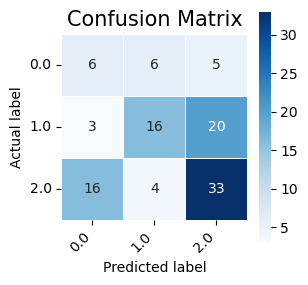

In [38]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)